a) Promovati: 250/500 (50.0%). Datele sunt BALANSATE.

b) Granita medie (std): 0 = 0.27 + 3.72*Studiu + 5.04*Somn


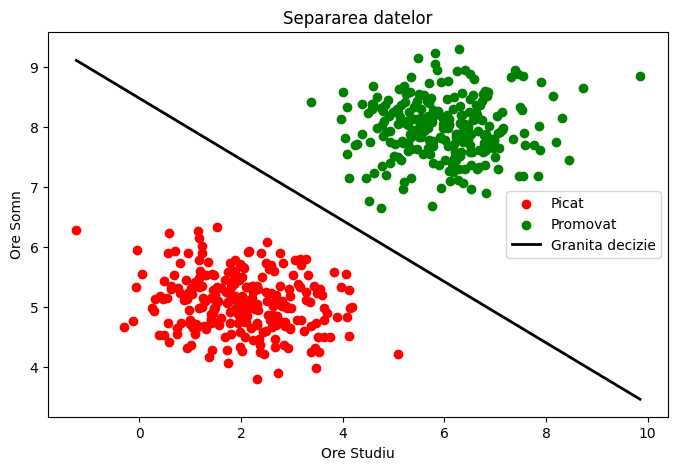

Raspuns: Datele NU sunt bine separate (exista zona de suprapunere).

c) Studiu (std): 3.72, Somn (std): 5.04
Raspuns: Orele de SOMN influenteaza mai mult promovabilitatea.


In [7]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

#a
df = pd.read_csv('date_promovare_examen.csv')
df.columns = ['Studiu', 'Somn', 'Promovare']

nr_promovati = df['Promovare'].sum()
total = len(df)
procent = nr_promovati / total
print(f"a) Promovati: {nr_promovati}/{total} ({procent:.1%}). Datele sunt {'BALANSATE' if 0.4 <= procent <= 0.6 else 'NEBALANSATE'}.")

X = df[['Studiu', 'Somn']].values
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_s = (X - X_mean) / X_std
y = df['Promovare'].values

with pm.Model() as model_logistic:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=2, shape=2)

    mu = alpha + pm.math.dot(X_s, betas)
    p = pm.math.sigmoid(mu)

    y_pred = pm.Bernoulli('y_pred', p=p, observed=y)

    idata = pm.sample(2000, tune=2000, return_inferencedata=True, progressbar=False,target_accept=0.95)


#b
summary = az.summary(idata, var_names=['alpha', 'betas'])
a_m = summary.loc['alpha', 'mean']
b1_m = summary.loc['betas[0]', 'mean']
b2_m = summary.loc['betas[1]', 'mean']

print(f"\nb) Granita medie (std): 0 = {a_m:.2f} + {b1_m:.2f}*Studiu + {b2_m:.2f}*Somn")

plt.figure(figsize=(8, 5))
plt.scatter(df['Studiu'][y==0], df['Somn'][y==0], c='red', label='Picat')
plt.scatter(df['Studiu'][y==1], df['Somn'][y==1], c='green', label='Promovat')

x_vals = np.linspace(df['Studiu'].min(), df['Studiu'].max(), 100)
x_vals_s = (x_vals - X_mean[0]) / X_std[0]
y_vals_s = -(a_m + b1_m * x_vals_s) / b2_m
y_vals = y_vals_s * X_std[1] + X_mean[1]

plt.plot(x_vals, y_vals, 'k-', linewidth=2, label='Granita decizie')
plt.xlabel('Ore Studiu')
plt.ylabel('Ore Somn')
plt.legend()
plt.title('Separarea datelor')
plt.show()

print("Raspuns: Datele NU sunt bine separate (exista zona de suprapunere).")


#c
print(f"\nc) Studiu (std): {b1_m:.2f}, Somn (std): {b2_m:.2f}")

if abs(b1_m) > abs(b2_m):
    print("Raspuns: Orele de STUDIU influenteaza mai mult promovabilitatea.")
else:
    print("Raspuns: Orele de SOMN influenteaza mai mult promovabilitatea.")